successfully loaded 17166 entries
[-0.41225029  0.41225029  0.95535919 ...  0.12963723 -0.29849699
 -0.48986996]


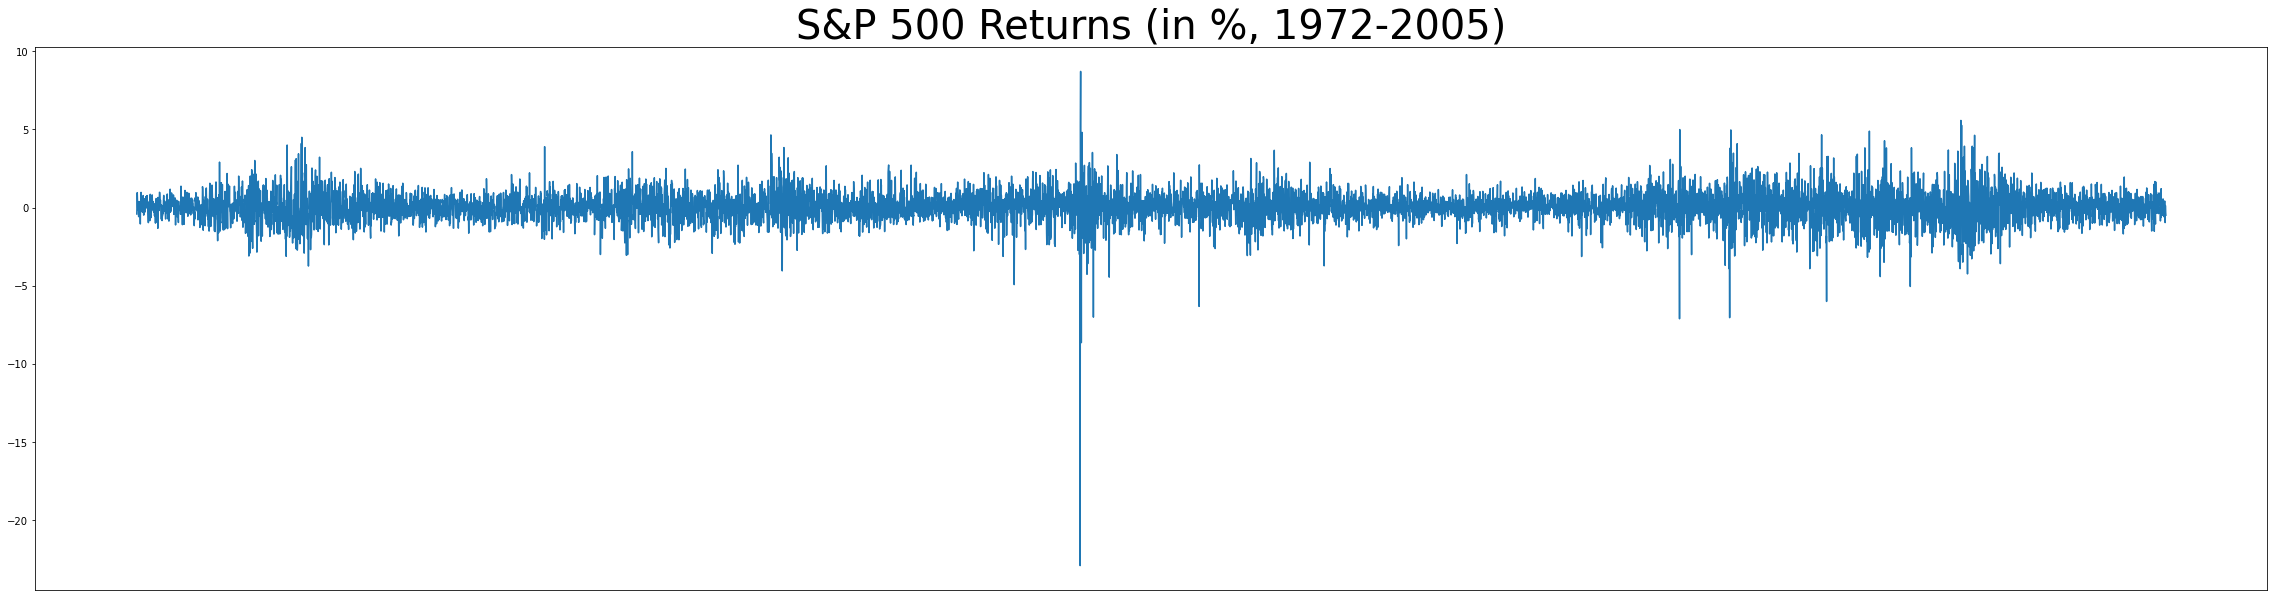

Calculating Metropolis-Hastings random walk...
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900
iter: 1000
iter: 1100
iter: 1200
iter: 1300
iter: 1400
iter: 1500
iter: 1600
iter: 1700
iter: 1800
iter: 1900
iter: 2000
iter: 2100
iter: 2200
iter: 2300
iter: 2400
iter: 2500
iter: 2600
iter: 2700
iter: 2800
iter: 2900
iter: 3000
iter: 3100
iter: 3200
iter: 3300
iter: 3400
iter: 3500
iter: 3600
iter: 3700
iter: 3800
iter: 3900
iter: 4000
iter: 4100
iter: 4200
iter: 4300
iter: 4400
iter: 4500
iter: 4600
iter: 4700
iter: 4800
iter: 4900
iter: 5000
iter: 5100
iter: 5200
iter: 5300
iter: 5400
iter: 5500
iter: 5600
iter: 5700
iter: 5800
iter: 5900
iter: 6000
iter: 6100
iter: 6200
iter: 6300
iter: 6400
iter: 6500
iter: 6600
iter: 6700
iter: 6800
iter: 6900
iter: 7000
iter: 7100
iter: 7200
iter: 7300
iter: 7400
iter: 7500
iter: 7600
iter: 7700
iter: 7800
iter: 7900
iter: 8000
iter: 8100
iter: 8200
iter: 8300
iter: 8400
iter: 8500
iter: 8600
iter: 8700
iter:

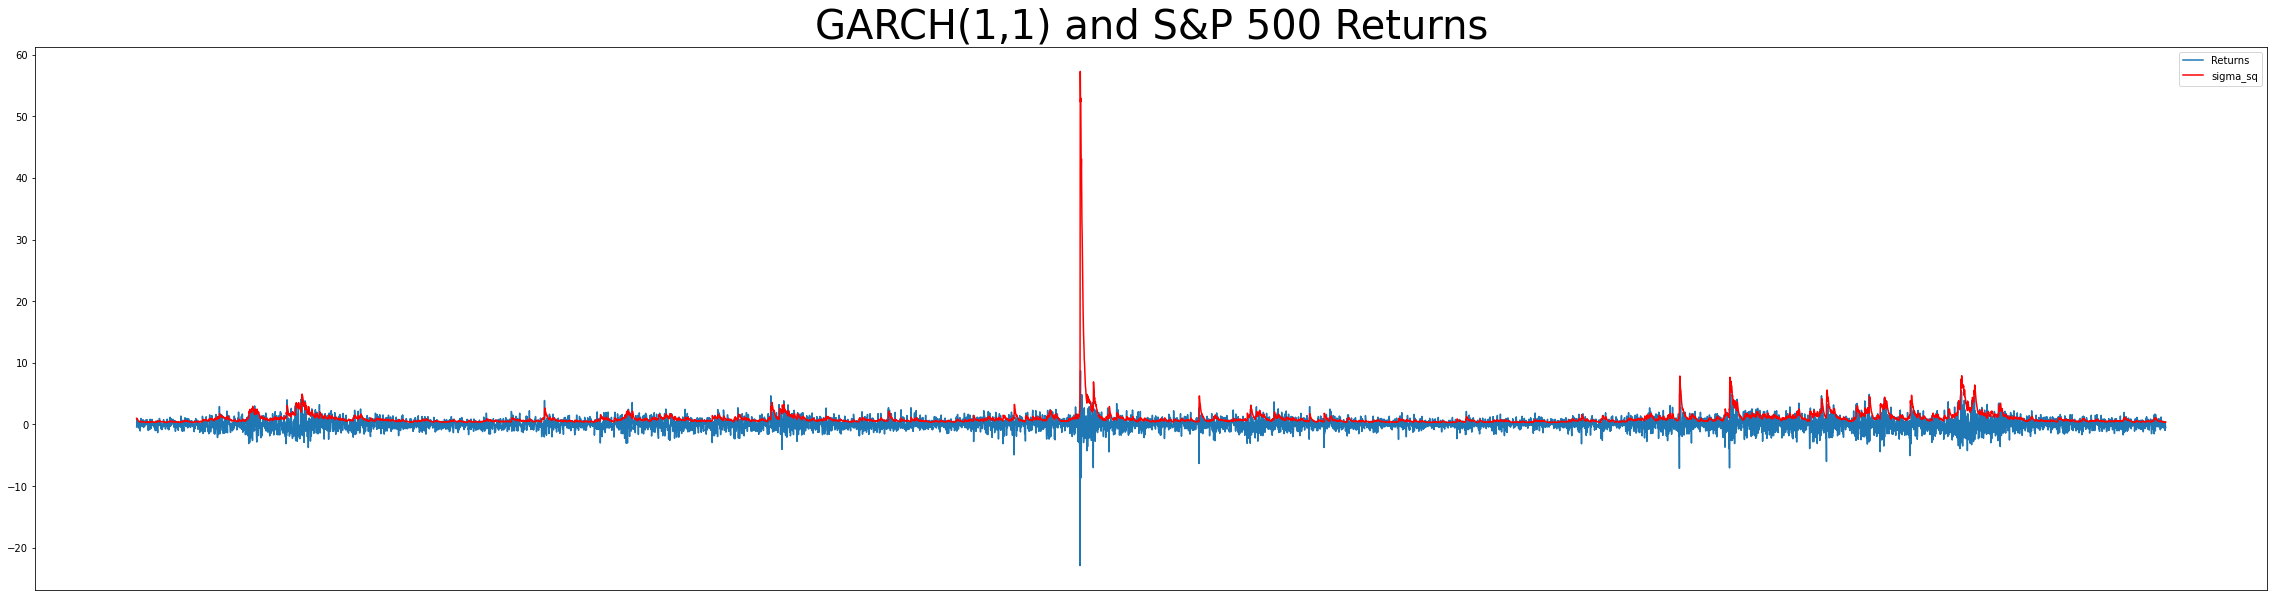

'\nhave sample of draws of posterior estimate\n\nuse first 80% of draws to estimate model\n\nuse remaining 20% to do predictive analysis\n\n(split up data into test and training)\n\n\ncompute vector of sigma average when computing likelihood\naverage sigma_t for every t\nplot it versus data\n\ncompare with ARCH model ???\ncompute log-score\n\n'

In [28]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

NUM_ITERS = 50000
BURN_IN = 400

HIGH_ACCEPT_THRESHOLD = 0.8
LOW_ACCEPT_THRESHOLD = 0.2

LOAD = False

class MetropolisHastingsGARCH:
    
    def __init__(self, num_iters, burn_in, returns):
        self.NUM_ITERS = num_iters # simulation iterations post-burn-in
        self.BURN_IN = burn_in # burn-in iterations 
        self.TOTAL_SIM_ITERS = self.NUM_ITERS + self.BURN_IN # total simulation iterations
        self.PROG_LOG_STEP = 100 # how often to log progress
        
        # set returns
        self.returns = returns
        
        # simulation value arrays
        self.sim_omega = np.zeros(self.TOTAL_SIM_ITERS)
        self.sim_alpha = np.zeros(self.TOTAL_SIM_ITERS)
        self.sim_beta = np.zeros(self.TOTAL_SIM_ITERS)
        
        self.avg_sigma_sq = np.zeros(len(returns))
        
    '''
    Only call after calling random walk
    '''
    def get_sigma_sq_results(self):
        return self.avg_sigma_sq
        
        
    '''
    Prior(omega) follows an inverse gamma distribution. Choose hyperparameters 
    '''
    def log_omega_prior(self, omega, g_alpha, g_beta):
        # can look up the density ? if want to?
        g = stats.invgamma.pdf(omega, g_alpha, scale=g_beta)
        if g < 0:
            print("NEGATIVE IN LOG PRIOR OMEGA")
        return np.log(g)
    
    '''
    Prior(alpha, beta), uniform improper prior proportional to 1{alpha>0, beta>0, alpha+beta < 1}
    CONSTANT, IS NOT USED IN ACCPETANCE PROBABILITY SINCE IT CANCELS OUT
    '''
    def log_alpha_beta_prior(self):
        # simulate from uniform for alpha and beta
        # prior predictive analysis -- keep only data that follows constraints
        return 0.0
    
    
    '''
    Returns the variance expression of a GARCH(1,1) process.
    '''
    def garch_filter(self, omega, alpha, beta):
               
        # Length of log_returns
        length = len(self.returns)
        
        # Initializing an empty array
        sigma_sq = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_sq[i] = omega / (1 - alpha - beta)
            else:
                sigma_sq[i] = omega + (alpha * (self.returns[i-1]**2)) + (beta * sigma_sq[i-1])
                
        return sigma_sq
        
        
    '''
    Likelihood function, is this good?
    '''
    def log_likelihood(self, omega, alpha, beta):
        
        sigma_sq = self.garch_filter(omega, alpha, beta)
        
        log_term = 2*np.pi*sigma_sq
        
        if np.min(log_term) < 0:
            print("NEGATIVE INNER TERM IN LOG LIKELIHOOD")
        
        log_likelihood = -0.5 * np.sum(np.log(log_term) + (self.returns**2)/sigma_sq)
        
        return log_likelihood
    

    '''
    Metropolis-Hastings random walk
    '''
    def random_walk_garch(self):

        '''
        Start with an initial state, which can be any value within the parameter space.

        Choose a proposal distribution, which is a probability distribution that specifies 
        how to generate a new candidate state given the current state. 
        In the GARCH case, for parameters

        Generate a candidate state by drawing a sample from the proposal distribution.

        Compute the acceptance ratio, which is the ratio of the posterior probability of 
        the candidate state to the posterior probability of the current state.

        Accept or reject the candidate state based on the acceptance ratio. 
        If the acceptance ratio is greater than or equal to 1, 
        then accept the candidate state as the new current state. 
        If the acceptance ratio is less than 1, 
        then accept the candidate state with probability equal to the acceptance ratio, 
        otherwise reject the candidate state and keep the current state as is.

        '''
        
        '''
        %     % Alternative, random walk MH block for h
        %     h_p = normrnd(sim_h(sim-1), std_rwmh);
        %     if h_p > 0 && rand < exp((barAh-1)*log(h_p/sim_h(sim-1))-barBh*(h_p-sim_h(sim-1)))
        %         sim_h(sim) = h_p;
        %         hAccCount = hAccCount + 1;
        %     else
        %         sim_h(sim) = sim_h(sim-1);
        %     end
        %     if sim < 0.1*Nsim && floor(sim/100) == sim/100 
        %         h_acc_rate = hAccCount/sim;
        %         if h_acc_rate > 0.8, std_rwmh = std_rwmh*2;end
        %         if h_acc_rate < 0.2, std_rwmh = std_rwmh*0.5; end
        %     end
        
        
        %     if sim < 0.1*Nsim && floor(sim/100) == sim/100 
        %         h_acc_rate = hAccCount/sim;
        %         if h_acc_rate > 0.8, std_rwmh = std_rwmh*2;end
        %         if h_acc_rate < 0.2, std_rwmh = std_rwmh*0.5; end
        
        '''
        
        # parameters for priors 
        # choose based on expected mean for omega, variance not too small, LOOK AT INV GAMMA STUFF
        g_a_prior = 3.0
        g_b_prior = 2.0
        
        # start with some arbitrary var for proposals 
        var_covar_prop = np.zeros((3, 3))
        var_covar_prop[0, 0] = 0.75 # omega variance
        var_covar_prop[1, 1] = 0.3 # alpha variance
        var_covar_prop[2, 2] = 0.3 # beta variance
        
        # want acceptance in between 0.2 and 0.8
        # need to adjust proposal std 
        omega_acc_count = 0
        ab_acc_count = 0
        
        
        # initialize simulation chain in a sensible way (what's a sensible way?)
        self.sim_omega[0] = 0.1
        self.sim_alpha[0] = 0.1
        self.sim_beta[0] = 0.85
        
        
        for i in range(1, self.TOTAL_SIM_ITERS):
            
            if i % 100 == 0:
                print("iter: " + str(i))
            
            # random walk block for omega parameter
            
            # np.random.normal mvn -> size 3 with var covariance matrix 
            
            omega_b = self.sim_omega[i - 1]
            alpha_b = self.sim_alpha[i - 1]
            beta_b = self.sim_beta[i - 1]
            
            # generate candidate values from some proposal distribution q(param*| param), in this multivar normal
            means = np.asarray([omega_b, alpha_b, beta_b])
            draws = np.random.multivariate_normal(means, var_covar_prop)
            
            # grab individual proposals
            omega_p = draws[0]    
            alpha_p = draws[1]
            beta_p = draws[2]
            
            # save computed likelihoods
            ll_before = self.log_likelihood(omega_b, alpha_b, beta_b)
            
            # ----- random walk block for omega -----
            
            # see if we accept this candidate, apply omega constraint > 0
            if omega_p > 0:
                # metropolis-hastings acceptance probability
                omega_accept = np.exp((self.log_likelihood(omega_p, alpha_b, beta_b) + self.log_omega_prior(omega_p, g_a_prior, g_b_prior)) - (ll_before + self.log_omega_prior(omega_b, g_a_prior, g_b_prior)))
                if np.random.random() < omega_accept:
                    # accept the candidate
                    self.sim_omega[i] = omega_p
                    omega_acc_count += 1
                else:
                    # reject candidate, use prev value
                    self.sim_omega[i] = omega_b
            else:
                # reject candidate, use prev value
                self.sim_omega[i] = omega_b
            
            # ----- random walk block for alpha, beta parameter -----
            
            # apply alpha and beta constraints
            if alpha_p > 0 and beta_p > 0 and ((alpha_p + beta_p) < 1):
                # metropolis-hastings acceptance probability
                alpha_beta_accept = np.exp(self.log_likelihood(omega_b, alpha_p, beta_p) - ll_before)
                if np.random.random() < alpha_beta_accept: 
                    # accept the candidates
                    self.sim_alpha[i] = alpha_p
                    self.sim_beta[i] = beta_p
                    ab_acc_count += 1
                else:
                    # reject candidates, use prev values
                    self.sim_alpha[i] = alpha_b
                    self.sim_beta[i] = beta_b
            else:
                # reject candidates, use prev values
                self.sim_alpha[i] = alpha_b
                self.sim_beta[i] = beta_b
            
            # update sigma_sq averages with the accepted values
            self.avg_sigma_sq += self.garch_filter(self.sim_omega[i], self.sim_alpha[i], self.sim_beta[i])
            
            '''
            adjust correlations and relative scale when adjusting prop std
            
            first assume no covariance, values diagonal matrix, hard code
            
            run MCMC and then take into account correlation in between them
            
            after a while, have bunch of vectors of 3 draws of parameters. "sample of vectors after a while"
            compute sample variance-covariance matrix USE NP.COV
            
            have var-covar matrix to pass in
            
            can scale it by 2 or 0.5 depending on accuracy of reject/accept
            '''
            # adjust variance-covariance matrix every so often in the beginning
            if i < (self.TOTAL_SIM_ITERS / 10) and (i % 100) == 0:
                
                # recalc cov matrix using all the samples we have so far
                var_covar_prop = np.cov(np.vstack((self.sim_omega[:i+1], self.sim_alpha[:i+1], self.sim_beta[:i+1])))
                
                # get acceptance percentages
                omega_acc_percent = omega_acc_count / i
                ab_acc_percent = ab_acc_count / i
                
                # avg_percent
                avg_perc = (omega_acc_percent + ab_acc_percent / 2)
                
                # if the average acceptance percent is too high
                if avg_perc > HIGH_ACCEPT_THRESHOLD:
                    # increase the variation
                    var_covar_prop *= 2
                elif avg_perc < LOW_ACCEPT_THRESHOLD:
                    var_covar_prop *= 0.5
                    
        # compute average sigma_sq
        self.avg_sigma_sq /= self.TOTAL_SIM_ITERS
        
        return

    
#### ------ DATA PREPROCESSING ----------

# read data from file
sp500_data = np.genfromtxt('../data/SP500c_returns.txt', delimiter='', skip_header=1)

print("successfully loaded " + str(sp500_data.size) + " entries")

# extract returns from data
returns = sp500_data[:, 1]

# print the returns array
print(returns)

# plot returns
plt.figure(figsize=(40, 10))
plt.plot(returns)
plt.title("S&P 500 Returns (in %, 1972-2005)", fontsize=40)

# hide x-axis
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.show()


#### ------- POSTERIOR SIM --------

avg_sigma_sq = None

if LOAD:
    avg_sigma_sq = np.loadtxt("../data/sigma_sq.txt")
else:
    # create model sim
    mhrw_garch = MetropolisHastingsGARCH(NUM_ITERS, BURN_IN, returns)
    print("Calculating Metropolis-Hastings random walk...")
    mhrw_garch.random_walk_garch()

    # save sigma sq to file
    avg_sigma_sq = mhrw_garch.get_sigma_sq_results()
    np.savetxt("../data/sigma_sq_50k.txt", avg_sigma_sq)


#### -------- ASSESS MODEL -----------


# plot volatility against return
plt.figure(figsize=(40, 10))
plt.plot(returns, label='Returns')
plt.legend()
plt.plot(avg_sigma_sq, c='r', label='sigma_sq')
plt.legend()
plt.title("GARCH(1,1) and S&P 500 Returns", fontsize=40)

# hide x-axis
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.show()


'''
have sample of draws of posterior estimate

use first 80% of draws to estimate model

use remaining 20% to do predictive analysis

(split up data into test and training)


compute vector of sigma average when computing likelihood
average sigma_t for every t
plot it versus data

compare with ARCH model ???
compute log-score

'''